In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'  #this will be faster actually
print(device)

# pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

cpu


In [2]:
houses = pd.read_csv("data/характеристики_домов.csv", delimiter=';', encoding='utf-8')
temp = pd.read_csv("data/температура.csv", delimiter=';', encoding='utf-8')
consumed = pd.read_csv("data/объём_теплоты.csv", delimiter=';', encoding='utf-8')


# var_temp_ + houses = consumed
#    x1     +   x2   =    y


# consumed['date'].value_counts()
# temp.head()

In [3]:
#Кое где короче нет записей про температуру, наример 2022-04-03, дальше есть

new_temp = []

current_date = 0
temps=[]
humids=[]
for index, row in temp.iterrows():
    if row['date_start'].split()[0] != current_date:
        new_temp.append([current_date, np.array(temps), np.array(humids)])
        current_date = row['date_start'].split()[0]
        temps = []
        humids = []
    temps.append(float(row['temp'].replace(',', '.')))
    humids.append(row['humidity'])
    

    
# print(new_temp, len(temps))
new_temp = pd.DataFrame(new_temp, columns=['date', 'temp', 'humidity'])
temp = new_temp.drop(axis = 0, index=0)
# temp

In [4]:
houses['wall_type'] = (houses['wall_type'].fillna(value='Кирпич'))

roof_types = sklearn.preprocessing.LabelBinarizer().fit_transform(houses['wall_type'])
roof_types = pd.DataFrame(roof_types)
houses = pd.concat([houses, roof_types], axis=1)
houses = houses.drop('wall_type', axis=1)
# houses.head()

In [5]:
def make_df():
    df = []

    troubled_set = set()

    #ужасно, отвратительно, фу!
    #оно ещё и пятнацать минут времени требует
    for index, row in tqdm.tqdm(consumed.iterrows(), total=consumed.shape[0]):
        tmp = (((houses.loc[houses['address_uuid'] == row['address_uuid']]).iloc[:, 1:]))

        # простите пожалуйста мне стыдно за это
        if list(((temp.loc[temp['date'] == row['date']])).to_numpy()) == []:
            troubled_set.add(row['address_uuid'])
            continue
        if tmp.empty:
            troubled_set.add(row['address_uuid'])
            continue

        
        df.append([   row['value'], row['is_unreliable']] + 
                  (((temp.loc[temp['date'] == row['date']])['temp']).tolist()[0].tolist())[0:8] + 
                  ((temp.loc[temp['date'] == row['date']])['humidity']).tolist()[0].tolist()[0:8]  + 
                  (tmp.loc[tmp.index[0]]).tolist()
                  )

#         if index == 999:
#             break
    
    if troubled_set != set():
        print('Troubles with:', len(troubled_set))


    # (tmp.loc[tmp.index[0]]).tolist()
    #why is it making NaN's aaaaaaaaa
#     print(len(row))
    df = pd.DataFrame(df)
#     print(df.shape)   #39
    print(df.info())
    df.fillna(value=0, inplace=True)
    with open('df.pkl', 'wb') as f:
        pickle.dump(df, f)
#     print(df.head())
    return df


#Короче, можно попробовать обработанную штуку сохранить через pickle
#чтобы потом ее просто открывать если надо

make_new = False
if ('df.pkl' not in os.listdir()) or make_new:
    print('Saved dataframe not found, making new...')
    df = make_df()
else:
    print('Found saved DataFrame!')
    with open('df.pkl', 'rb') as f:
        df = pickle.load(f)
#     print(df.head())


Found saved DataFrame!


In [6]:
scaler = sklearn.preprocessing.StandardScaler()
# temp_scaler = sklearn.preprocessing.MinMaxScaler()
features_to_normalize = list(range(2, df.shape[1]))


scaler.fit(df[features_to_normalize])
df[features_to_normalize] = scaler.transform(df[features_to_normalize])


# df[0] = temp_scaler.fit_transform(df[0].values.reshape(-1, 1))


In [7]:
to_save = {'houses': houses, 'scaler':scaler}#, 'temp_scaler':temp_scaler}
with open(os.path.join('..', 'model', 'houses.pkl'), 'wb') as f:
    pickle.dump(to_save, f)

In [8]:
train, test = train_test_split(df, test_size = 0.02, random_state=42)
train, val = train_test_split(train, test_size = 0.01, random_state=42)
# print(train.shape, test.shape, val.shape)

x_train = (train.loc[:, '1':])
y_train = (train.loc[:, '0':'0'])

x_test = (test.loc[:, '1':])
y_test = (test.loc[:, '0':'0'])

x_val = (val.loc[:, '1':])
y_val = (val.loc[:, '0':'0'])


x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()


#350 it/s before adding .to(device), 450 after
# while just running on cpu will be 600-700, I don't get it
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)



In [9]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Linear(128, 64), 
    nn.ReLU(),
    nn.Linear(64, 1)
)

In [10]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

100%|███████████████████████████████████████████████████████████████████████████| 54706/54706 [00:55<00:00, 986.39it/s]
C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11278, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████████████████████████████████████| 54706/54706 [00:55<00:00, 979.15it/s]


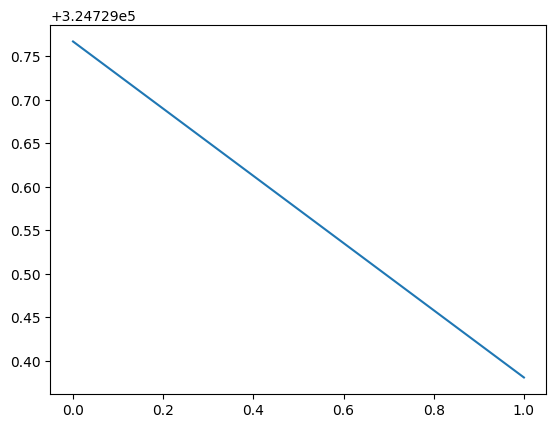

In [11]:
import copy

n_epochs = 2
batch_size = 10
batch_start = torch.arange(0, len(train), batch_size)

best_mse = np.inf
best_weights = None
history = []

model.to(device)

for epoch in (range(n_epochs)):
    model.train()
#     with tqdm.tqdm(batch_start, unit='batch', mininterval=0, disable=True) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for start in bar:
    for start in tqdm.tqdm(batch_start, total=len(batch_start)):
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
#             print('x_', x_batch[0])
            
            y_pred = model(x_batch)
#             print(y_pred)
            loss = loss_fn(y_pred, y_batch)
#             print(loss, end='\r')
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
#             bar.set_postfix(mse=float(loss))
#         bar.update()
    
    model.eval()
    tmp_mse = 0
    for index, x_batch in enumerate(x_test):
#         x_batch = x_batch
        y_pred = model(x_batch)
#         print(y_test.shape, index)
        
#         y_test = y_test[index]
        
        mse = loss_fn(y_pred, y_test)
        
        mse = float(mse)
        tmp_mse += mse
    mse = tmp_mse/len(x_test)
#     print(epoch, mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
            
model.load_state_dict(best_weights)
torch.save(model.state_dict(), os.path.join('..', 'model', 'model.pt'))


plt.plot(history)
plt.show()

In [12]:
torch.save(model.state_dict(), os.path.join('..', 'model', 'model.pt'))


In [13]:
model.load_state_dict(torch.load(os.path.join('..', 'model', 'model.pt')))

model.eval()
error_sum = 0
for index, x in enumerate(x_val):
    y_pred = model(x_val[index])

#     predicted_temp = temp_scaler.inverse_transform(y_pred.cpu().detach().unsqueeze(0))
    predicted_temp = y_pred
    
    target_temp = y_val[index]
    print(target_temp, predicted_temp)
#     target_temp = temp_scaler.inverse_transform(y_val[index].unsqueeze(0))
    error_sum = abs(predicted_temp - target_temp)
#     print(predicted_temp - target_temp, predicted_temp, target_temp)
    

    #, temp_scaler.inverse_transform(y_val[index]))
#     print((err) ,y_pred, y_val[index])
    

print(error_sum/len(x_val))


# 50 epochs without normalizing 3.5 or something
# 100 epochs without normalizing 4.4

tensor([6.1600]) tensor([4.1502], grad_fn=<ViewBackward0>)
tensor([4.2680]) tensor([3.9276], grad_fn=<ViewBackward0>)
tensor([1.7870]) tensor([0.0834], grad_fn=<ViewBackward0>)
tensor([4.0210]) tensor([3.7107], grad_fn=<ViewBackward0>)
tensor([4.2630]) tensor([3.7158], grad_fn=<ViewBackward0>)
tensor([3.4190]) tensor([1.8418], grad_fn=<ViewBackward0>)
tensor([2.1400]) tensor([2.4035], grad_fn=<ViewBackward0>)
tensor([0.3480]) tensor([0.5521], grad_fn=<ViewBackward0>)
tensor([4.0960]) tensor([3.1934], grad_fn=<ViewBackward0>)
tensor([1.5540]) tensor([0.9789], grad_fn=<ViewBackward0>)
tensor([4.1890]) tensor([4.4509], grad_fn=<ViewBackward0>)
tensor([2.8250]) tensor([1.6821], grad_fn=<ViewBackward0>)
tensor([2.9800]) tensor([3.2943], grad_fn=<ViewBackward0>)
tensor([3.1810]) tensor([2.9583], grad_fn=<ViewBackward0>)
tensor([0.8960]) tensor([2.3129], grad_fn=<ViewBackward0>)
tensor([5.3260]) tensor([4.1550], grad_fn=<ViewBackward0>)
tensor([3.9620]) tensor([5.0531], grad_fn=<ViewBackward0

tensor([1.9140]) tensor([1.2272], grad_fn=<ViewBackward0>)
tensor([2.5420]) tensor([1.7218], grad_fn=<ViewBackward0>)
tensor([1.7080]) tensor([0.4999], grad_fn=<ViewBackward0>)
tensor([2.7060]) tensor([2.2439], grad_fn=<ViewBackward0>)
tensor([2.4370]) tensor([2.3185], grad_fn=<ViewBackward0>)
tensor([3.6080]) tensor([2.8060], grad_fn=<ViewBackward0>)
tensor([5.1970]) tensor([3.9794], grad_fn=<ViewBackward0>)
tensor([1.0420]) tensor([2.0481], grad_fn=<ViewBackward0>)
tensor([5.6890]) tensor([1.7614], grad_fn=<ViewBackward0>)
tensor([3.4390]) tensor([2.0789], grad_fn=<ViewBackward0>)
tensor([2.3660]) tensor([1.7179], grad_fn=<ViewBackward0>)
tensor([4.6460]) tensor([4.5572], grad_fn=<ViewBackward0>)
tensor([2.8730]) tensor([1.2642], grad_fn=<ViewBackward0>)
tensor([5.4520]) tensor([4.3124], grad_fn=<ViewBackward0>)
tensor([2.2510]) tensor([1.6158], grad_fn=<ViewBackward0>)
tensor([0.2710]) tensor([0.5610], grad_fn=<ViewBackward0>)
tensor([3.9140]) tensor([3.2355], grad_fn=<ViewBackward0

tensor([3.6120]) tensor([2.7798], grad_fn=<ViewBackward0>)
tensor([2.8480]) tensor([2.5035], grad_fn=<ViewBackward0>)
tensor([3.8050]) tensor([3.9419], grad_fn=<ViewBackward0>)
tensor([3.8260]) tensor([3.5837], grad_fn=<ViewBackward0>)
tensor([0.5040]) tensor([1.9177], grad_fn=<ViewBackward0>)
tensor([2.1570]) tensor([2.0194], grad_fn=<ViewBackward0>)
tensor([4.2610]) tensor([2.4263], grad_fn=<ViewBackward0>)
tensor([3.3530]) tensor([3.3069], grad_fn=<ViewBackward0>)
tensor([2.7810]) tensor([2.4716], grad_fn=<ViewBackward0>)
tensor([2.4770]) tensor([2.0641], grad_fn=<ViewBackward0>)
tensor([4.2790]) tensor([3.0411], grad_fn=<ViewBackward0>)
tensor([2.9000]) tensor([2.5080], grad_fn=<ViewBackward0>)
tensor([0.2790]) tensor([1.2578], grad_fn=<ViewBackward0>)
tensor([5.5660]) tensor([3.9522], grad_fn=<ViewBackward0>)
tensor([2.6930]) tensor([1.5535], grad_fn=<ViewBackward0>)
tensor([4.1620]) tensor([3.3165], grad_fn=<ViewBackward0>)
tensor([5.5180]) tensor([4.3579], grad_fn=<ViewBackward0

tensor([0.]) tensor([3.4369], grad_fn=<ViewBackward0>)
tensor([0.3980]) tensor([1.9366], grad_fn=<ViewBackward0>)
tensor([3.3490]) tensor([2.2047], grad_fn=<ViewBackward0>)
tensor([2.5780]) tensor([2.8060], grad_fn=<ViewBackward0>)
tensor([3.7090]) tensor([2.9952], grad_fn=<ViewBackward0>)
tensor([2.6110]) tensor([2.2886], grad_fn=<ViewBackward0>)
tensor([2.4930]) tensor([3.1391], grad_fn=<ViewBackward0>)
tensor([1.9810]) tensor([0.4897], grad_fn=<ViewBackward0>)
tensor([3.9770]) tensor([2.8909], grad_fn=<ViewBackward0>)
tensor([2.4410]) tensor([2.5986], grad_fn=<ViewBackward0>)
tensor([2.3450]) tensor([2.1281], grad_fn=<ViewBackward0>)
tensor([2.5750]) tensor([0.9889], grad_fn=<ViewBackward0>)
tensor([9.1950]) tensor([3.4406], grad_fn=<ViewBackward0>)
tensor([3.5000]) tensor([2.9775], grad_fn=<ViewBackward0>)
tensor([2.9140]) tensor([1.6069], grad_fn=<ViewBackward0>)
tensor([3.6830]) tensor([2.4137], grad_fn=<ViewBackward0>)
tensor([2.3690]) tensor([2.9205], grad_fn=<ViewBackward0>)
t

tensor([3.9330]) tensor([2.9571], grad_fn=<ViewBackward0>)
tensor([3.1520]) tensor([2.9840], grad_fn=<ViewBackward0>)
tensor([4.7190]) tensor([3.1119], grad_fn=<ViewBackward0>)
tensor([7.0220]) tensor([6.8294], grad_fn=<ViewBackward0>)
tensor([2.8730]) tensor([3.2665], grad_fn=<ViewBackward0>)
tensor([1.8350]) tensor([0.8160], grad_fn=<ViewBackward0>)
tensor([2.8430]) tensor([1.7533], grad_fn=<ViewBackward0>)
tensor([6.0070]) tensor([5.3629], grad_fn=<ViewBackward0>)
tensor([3.3340]) tensor([2.8769], grad_fn=<ViewBackward0>)
tensor([1.1900]) tensor([1.2907], grad_fn=<ViewBackward0>)
tensor([5.7620]) tensor([2.6705], grad_fn=<ViewBackward0>)
tensor([5.7350]) tensor([3.2735], grad_fn=<ViewBackward0>)
tensor([2.9460]) tensor([2.6317], grad_fn=<ViewBackward0>)
tensor([3.4760]) tensor([2.7662], grad_fn=<ViewBackward0>)
tensor([5.6270]) tensor([6.5867], grad_fn=<ViewBackward0>)
tensor([2.7430]) tensor([2.3714], grad_fn=<ViewBackward0>)
tensor([5.7320]) tensor([2.8693], grad_fn=<ViewBackward0

tensor([3.1600]) tensor([3.0197], grad_fn=<ViewBackward0>)
tensor([2.4840]) tensor([2.6029], grad_fn=<ViewBackward0>)
tensor([2.4660]) tensor([2.1200], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([0.9812], grad_fn=<ViewBackward0>)
tensor([3.5560]) tensor([3.6622], grad_fn=<ViewBackward0>)
tensor([7.0090]) tensor([5.8275], grad_fn=<ViewBackward0>)
tensor([3.9270]) tensor([3.8557], grad_fn=<ViewBackward0>)
tensor([1.9180]) tensor([2.3296], grad_fn=<ViewBackward0>)
tensor([5.7110]) tensor([4.0115], grad_fn=<ViewBackward0>)
tensor([1.8120]) tensor([1.3191], grad_fn=<ViewBackward0>)
tensor([3.6660]) tensor([2.9440], grad_fn=<ViewBackward0>)
tensor([1.3170]) tensor([1.6892], grad_fn=<ViewBackward0>)
tensor([2.5720]) tensor([1.2377], grad_fn=<ViewBackward0>)
tensor([1.6720]) tensor([1.5310], grad_fn=<ViewBackward0>)
tensor([3.0880]) tensor([2.7876], grad_fn=<ViewBackward0>)
tensor([7.1430]) tensor([3.9616], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([1.1543], grad_fn=<ViewBackward0>)
tenso

tensor([1.6540]) tensor([1.1962], grad_fn=<ViewBackward0>)
tensor([6.1680]) tensor([2.9420], grad_fn=<ViewBackward0>)
tensor([2.7780]) tensor([1.2934], grad_fn=<ViewBackward0>)
tensor([4.5190]) tensor([2.3708], grad_fn=<ViewBackward0>)
tensor([4.4310]) tensor([4.1678], grad_fn=<ViewBackward0>)
tensor([3.2130]) tensor([2.7996], grad_fn=<ViewBackward0>)
tensor([4.1950]) tensor([3.3023], grad_fn=<ViewBackward0>)
tensor([6.5030]) tensor([5.4847], grad_fn=<ViewBackward0>)
tensor([4.0770]) tensor([3.8915], grad_fn=<ViewBackward0>)
tensor([2.8330]) tensor([3.0258], grad_fn=<ViewBackward0>)
tensor([1.8630]) tensor([1.4762], grad_fn=<ViewBackward0>)
tensor([4.7370]) tensor([3.5627], grad_fn=<ViewBackward0>)
tensor([5.1420]) tensor([3.4633], grad_fn=<ViewBackward0>)
tensor([4.7500]) tensor([4.0148], grad_fn=<ViewBackward0>)
tensor([3.0900]) tensor([1.1305], grad_fn=<ViewBackward0>)
tensor([4.3840]) tensor([4.3977], grad_fn=<ViewBackward0>)
tensor([2.3370]) tensor([3.2257], grad_fn=<ViewBackward0

tensor([1.8220]) tensor([1.8283], grad_fn=<ViewBackward0>)
tensor([1.4220]) tensor([1.1882], grad_fn=<ViewBackward0>)
tensor([2.9260]) tensor([2.1033], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([0.5105], grad_fn=<ViewBackward0>)
tensor([4.4340]) tensor([4.9402], grad_fn=<ViewBackward0>)
tensor([0.8880]) tensor([2.7467], grad_fn=<ViewBackward0>)
tensor([2.6630]) tensor([1.5525], grad_fn=<ViewBackward0>)
tensor([6.3950]) tensor([4.2002], grad_fn=<ViewBackward0>)
tensor([7.3520]) tensor([4.5205], grad_fn=<ViewBackward0>)
tensor([3.0970]) tensor([2.0920], grad_fn=<ViewBackward0>)
tensor([3.7790]) tensor([5.0301], grad_fn=<ViewBackward0>)
tensor([3.8920]) tensor([3.4674], grad_fn=<ViewBackward0>)
tensor([4.5600]) tensor([3.8484], grad_fn=<ViewBackward0>)
tensor([5.4520]) tensor([4.7151], grad_fn=<ViewBackward0>)
tensor([2.9360]) tensor([2.9711], grad_fn=<ViewBackward0>)
tensor([4.8590]) tensor([2.9939], grad_fn=<ViewBackward0>)
tensor([3.5810]) tensor([2.6255], grad_fn=<ViewBackward0>)
t

tensor([2.0940]) tensor([2.1305], grad_fn=<ViewBackward0>)
tensor([2.5520]) tensor([2.6906], grad_fn=<ViewBackward0>)
tensor([3.1450]) tensor([2.3716], grad_fn=<ViewBackward0>)
tensor([2.6760]) tensor([2.1881], grad_fn=<ViewBackward0>)
tensor([0.4910]) tensor([-0.0900], grad_fn=<ViewBackward0>)
tensor([5.2670]) tensor([3.0523], grad_fn=<ViewBackward0>)
tensor([7.0080]) tensor([6.4714], grad_fn=<ViewBackward0>)
tensor([4.2230]) tensor([3.5100], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([1.7069], grad_fn=<ViewBackward0>)
tensor([2.5140]) tensor([2.3944], grad_fn=<ViewBackward0>)
tensor([8.3270]) tensor([7.3221], grad_fn=<ViewBackward0>)
tensor([2.3590]) tensor([3.4800], grad_fn=<ViewBackward0>)
tensor([1.8060]) tensor([2.1128], grad_fn=<ViewBackward0>)
tensor([5.4770]) tensor([5.1353], grad_fn=<ViewBackward0>)
tensor([5.5770]) tensor([4.6892], grad_fn=<ViewBackward0>)
tensor([2.1880]) tensor([1.2835], grad_fn=<ViewBackward0>)
tensor([2.5830]) tensor([2.1974], grad_fn=<ViewBackward0>)


tensor([10.5700]) tensor([7.8548], grad_fn=<ViewBackward0>)
tensor([2.2320]) tensor([1.3776], grad_fn=<ViewBackward0>)
tensor([2.3580]) tensor([1.7125], grad_fn=<ViewBackward0>)
tensor([1.7130]) tensor([2.6218], grad_fn=<ViewBackward0>)
tensor([4.0820]) tensor([3.5731], grad_fn=<ViewBackward0>)
tensor([6.4500]) tensor([7.0884], grad_fn=<ViewBackward0>)
tensor([6.4660]) tensor([4.2112], grad_fn=<ViewBackward0>)
tensor([3.1000]) tensor([2.8967], grad_fn=<ViewBackward0>)
tensor([3.5920]) tensor([2.3840], grad_fn=<ViewBackward0>)
tensor([2.7700]) tensor([2.3967], grad_fn=<ViewBackward0>)
tensor([1.6860]) tensor([0.6444], grad_fn=<ViewBackward0>)
tensor([3.1760]) tensor([2.7499], grad_fn=<ViewBackward0>)
tensor([0.5620]) tensor([2.7156], grad_fn=<ViewBackward0>)
tensor([3.7580]) tensor([2.1969], grad_fn=<ViewBackward0>)
tensor([2.9280]) tensor([2.1369], grad_fn=<ViewBackward0>)
tensor([4.9300]) tensor([2.7925], grad_fn=<ViewBackward0>)
tensor([0.8940]) tensor([3.1884], grad_fn=<ViewBackward

tensor([4.2890]) tensor([4.2140], grad_fn=<ViewBackward0>)
tensor([5.2240]) tensor([4.9083], grad_fn=<ViewBackward0>)
tensor([3.4870]) tensor([2.1307], grad_fn=<ViewBackward0>)
tensor([0.4230]) tensor([0.3895], grad_fn=<ViewBackward0>)
tensor([5.2110]) tensor([4.5271], grad_fn=<ViewBackward0>)
tensor([0.9590]) tensor([0.0436], grad_fn=<ViewBackward0>)
tensor([5.7110]) tensor([2.2600], grad_fn=<ViewBackward0>)
tensor([4.7440]) tensor([2.1716], grad_fn=<ViewBackward0>)
tensor([0.3070]) tensor([1.4293], grad_fn=<ViewBackward0>)
tensor([2.6250]) tensor([2.4638], grad_fn=<ViewBackward0>)
tensor([3.4600]) tensor([2.6021], grad_fn=<ViewBackward0>)
tensor([7.0750]) tensor([6.9878], grad_fn=<ViewBackward0>)
tensor([6.7760]) tensor([6.1567], grad_fn=<ViewBackward0>)
tensor([4.5030]) tensor([3.5428], grad_fn=<ViewBackward0>)
tensor([3.2690]) tensor([3.6585], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([1.6955], grad_fn=<ViewBackward0>)
tensor([0.9960]) tensor([-0.4180], grad_fn=<ViewBackward0>)


tensor([2.5450]) tensor([1.9944], grad_fn=<ViewBackward0>)
tensor([4.7760]) tensor([3.7163], grad_fn=<ViewBackward0>)
tensor([4.1450]) tensor([3.8344], grad_fn=<ViewBackward0>)
tensor([0.2880]) tensor([1.0513], grad_fn=<ViewBackward0>)
tensor([8.4970]) tensor([6.5874], grad_fn=<ViewBackward0>)
tensor([2.4780]) tensor([2.9452], grad_fn=<ViewBackward0>)
tensor([0.5330]) tensor([1.2394], grad_fn=<ViewBackward0>)
tensor([2.0610]) tensor([2.1881], grad_fn=<ViewBackward0>)
tensor([2.8510]) tensor([1.9664], grad_fn=<ViewBackward0>)
tensor([2.9940]) tensor([1.8977], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([1.1889], grad_fn=<ViewBackward0>)
tensor([3.0170]) tensor([1.6667], grad_fn=<ViewBackward0>)
tensor([3.6230]) tensor([3.4858], grad_fn=<ViewBackward0>)
tensor([1.9670]) tensor([2.1824], grad_fn=<ViewBackward0>)
tensor([4.9370]) tensor([2.9217], grad_fn=<ViewBackward0>)
tensor([1.4760]) tensor([0.7755], grad_fn=<ViewBackward0>)
tensor([4.4880]) tensor([3.1370], grad_fn=<ViewBackward0>)
t

tensor([4.5690]) tensor([4.5626], grad_fn=<ViewBackward0>)
tensor([7.7000]) tensor([4.5305], grad_fn=<ViewBackward0>)
tensor([4.4950]) tensor([3.0676], grad_fn=<ViewBackward0>)
tensor([0.]) tensor([3.2124], grad_fn=<ViewBackward0>)
tensor([5.5770]) tensor([5.1606], grad_fn=<ViewBackward0>)
tensor([3.3780]) tensor([3.6426], grad_fn=<ViewBackward0>)
tensor([4.0240]) tensor([3.7352], grad_fn=<ViewBackward0>)
tensor([102.8960]) tensor([2.3563], grad_fn=<ViewBackward0>)
tensor([2.0640]) tensor([2.6538], grad_fn=<ViewBackward0>)
tensor([3.9150]) tensor([3.3135], grad_fn=<ViewBackward0>)
tensor([1.7920]) tensor([1.9609], grad_fn=<ViewBackward0>)
tensor([2.2660]) tensor([1.2019], grad_fn=<ViewBackward0>)
tensor([0.2370]) tensor([-1.0363], grad_fn=<ViewBackward0>)
tensor([1.9350]) tensor([2.5030], grad_fn=<ViewBackward0>)
tensor([1.6500]) tensor([2.0331], grad_fn=<ViewBackward0>)
tensor([3.5530]) tensor([1.4683], grad_fn=<ViewBackward0>)
tensor([2.6870]) tensor([3.2305], grad_fn=<ViewBackward0>

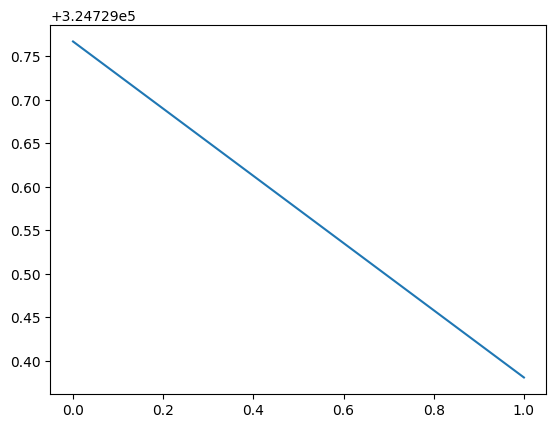

In [14]:
import matplotlib.pyplot as plt

plt.plot(history)